In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as c
from random import choice
from astropy.table import Table
import spectral_cube
from astropy.io import fits
import pylab as plt
plt.style.use('dark_background')

In [2]:
%run ../coelho_model_paa/compile_coelho_models.py

[0.0, -3.9724310250778787e-08, -9.224186294981774e-08, 2.747516056433065e-08, 1.663246903132191e-08, -3.558520264392704e-08]
[0.0, 1.5284878110754073e-08, -9.489724984173166e-08, 4.380682283722175e-08, 2.981937026712247e-08, 7.721562454871583e-09]
[0.0, -2.5556722588896658e-08, 3.511721587176825e-08, -4.964251660361756e-08, -5.374574151621217e-09, -2.9709784246634517e-08]
[0.0, -8.188043650503202e-09, -6.535436781187725e-08, -9.636761525716222e-09, -2.3006823495674253e-08, 1.901113659338023e-08]
[0.0, 1.0991959932020362e-08, -4.786856388152129e-09, 2.0327796783765723e-09, -2.2079364892324347e-09, -2.296731125084442e-08]


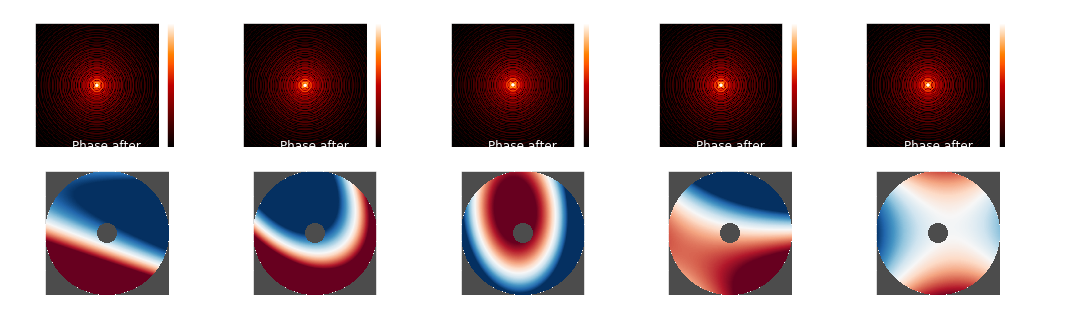

In [3]:
%run aperture_plane_model.py

In [4]:
fh = fits.open('./s_coelho14_sed/t03400_g+0.5_m13p04_sed.fits')

In [5]:
sp = lower_dimensional_structures.OneDSpectrum.from_hdu(fh)

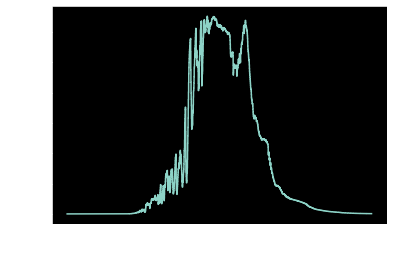

In [6]:
sp.quicklook()

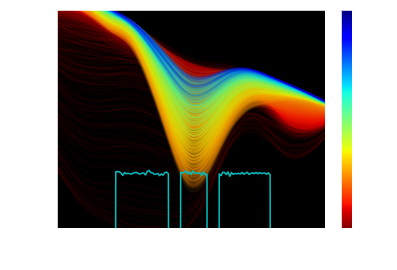

In [7]:
%run ../coelho_model_paa/coelho_specplot.py

In [8]:
models_table = table.Table.read('coelho14_model_paa.fits')

In [9]:
def value_keys(models_table):
    logg_values = []
    teff_values = []
    
    for value in models_table['logg']:
        if value not in logg_values:
            logg_values.append(value)
        
    for value in models_table['teff']:
        if value not in teff_values:
            teff_values.append(value)

    teff_dict = {"attribute": "effective temperature"}
    logg_dict = {"attribute": "surface gravity (log base 10)"}
    
    for value in teff_values:
        indices = []
        for ii in range(len(models_table)):
            if models_table['teff'][ii] == value:
                indices.append(ii)
        teff_dict[f'value is {value}'] = indices
    
    for value in logg_values:
        indices = []
        for ii in range(len(models_table)):
            if models_table['logg'][ii] == value:
                indices.append(ii)
        logg_dict[f'value is {value}'] = indices

    return teff_dict, logg_dict, teff_values, logg_values

In [10]:
teff_dict, logg_dict, teff_values, logg_values = value_keys(models_table)

In [11]:
def correct_keys(jj, models_table, tbl):
    keys = []
    
    init_min = np.argmin(np.abs(teff_values - tbl['teff'][jj]))
    teff_val = teff_values[init_min]
    init_min = np.argmin(np.abs(logg_values - tbl['logg'][jj]))
    logg_val = logg_values[init_min]
    
    keys_teff = teff_dict[f'value is {teff_val}']
    keys_logg = logg_dict[f'value is {logg_val}']
    
    for key in keys_teff:
        if key in keys_logg:
            keys.append(key)
            
    if len(keys) == 0:
        index = choice(keys_teff)
    else:
        index = choice(keys)
    
    return index

In [49]:
def closest_model(name, VVV=False):
    """"
    This assumes that we value teff being correct over logg.
    Unfortunately, trying to find the best fit from existing data requires us to use a strict poset.
    So one has to be prioritized over the other.
    """
    data_stars = np.loadtxt('./TRILEGAL_data/' + name, unpack=True)
    
    logTe = []
    logg = []
    Av = []
    J = []
    H = []
    Ks = []
    
    zpt_J = 1594*u.Jy
    zpt_H = 1024*u.Jy
    zpt_Ks = 666.8*u.Jy
    
    index = 13
    
    if VVV:
        index += 2
        zpt_J -= 44.2*u.Jy
        zpt_H += 2.4*u.Jy
        zpt_Ks += 5.8*u.Jy
        
    zpts = Table({'J': [zpt_J],
                 'H': [zpt_H],
                 'Ks': [zpt_Ks],
                 'mJ': [zpt_J],
                 'mH': [zpt_H],
                 'mK': [zpt_Ks],
    })

    for ii in range(len(data_stars[0])):
        if data_stars[index, ii] >= 16:
            logTe.append(data_stars[5, ii])
            logg.append(data_stars[6, ii])
            Av.append(data_stars[8, ii])
            J.append(data_stars[index - 2, ii])
            H.append(data_stars[index - 1, ii])
            Ks.append(data_stars[index, ii])

    tbl = Table({'logTe': logTe,
                 'logg': logg,
                 'Av': Av,
                 'J': J,
                 'H': H,
                 'Ks': Ks,
                 })

    tbl.add_column(col=(10**tbl['logTe']), name='teff')
    
    data_rows = []
    good_col = ['mag_paa', 'mag_paac_l', 'mag_paac_h', 'mJ', 'mH', 'mK', 'fn']
    kept_col = ['Av', 'J', 'H', 'Ks']
    
    for jj in range(len(tbl)):
        index = correct_keys(jj=jj, models_table=models_table, tbl=tbl)
        
        temp_dict = {}
        for hh in good_col:
            if hh is 'fn':
                temp_dict[f'{hh} model'] = models_table[hh][index]
            elif hh in zpts.colnames:
                temp_dict[f'{hh} model'] = models_table[hh][index]
                temp_dict[f'{hh} flux model'] = zpts[hh][0] * 10**(models_table[hh][index] / -2.5)
            else:
                temp_dict[f'{hh} model'] = models_table[hh][index]
                temp_dict[f'{hh} flux model'] = 10**(models_table[hh][index] / -2.5)
            
        for hh in kept_col:
            if hh is 'Av':
                temp_dict[f'{hh} tril'] = tbl[hh][jj]
            else:
                temp_dict[f'{hh} tril'] = tbl[hh][jj]
                temp_dict[f'{hh} flux tril'] = zpts[hh][0] * 10**(tbl[hh][jj] / -2.5)
        
        temp_dict['flux ratio'] = temp_dict['mK flux model'] / temp_dict['Ks flux tril']
        temp_dict['f_paa'] = temp_dict['flux ratio'] * temp_dict['mag_paa flux model'] *u.Jy
        temp_dict['f_paac_l'] = temp_dict['flux ratio'] * temp_dict['mag_paac_l flux model'] *u.Jy
        temp_dict['f_paac_h'] = temp_dict['flux ratio'] * temp_dict['mag_paac_h flux model'] *u.Jy
        
        data_rows.append(temp_dict)
        
    result = Table(rows=data_rows)
    
    return result

I'm going to run this with some fainter stars. Limiting mag will be 32, l=0.1, b=2.5, pix=50, area=0.00012531558641975312deg2.

In [50]:
data_m_1 = closest_model('data_m_1.dat')
data_v_1 = closest_model('data_v_1.dat', VVV=True)
data_m_1

Av tril,H flux tril,H tril,J flux tril,J tril,Ks flux tril,Ks tril,f_paa,f_paac_h,f_paac_l,flux ratio,fn model,mH flux model,mH model,mJ flux model,mJ model,mK flux model,mK model,mag_paa flux model,mag_paa model,mag_paac_h flux model,mag_paac_h model,mag_paac_l flux model,mag_paac_l model
float64,object,float64,object,float64,object,float64,object,object,object,float64,str43,object,float64,object,float64,object,float64,float64,float64,float64,float64,float64,float64
0.035,2.7358983445687774e-06 Jy,21.433,2.667401045501872e-06 Jy,21.941,2.331286190690023e-06 Jy,21.141,0.00016201137214749068 Jy,0.0003420459640767628 Jy,0.0004902602465581193 Jy,199.2047117030681,s_coelho14_sed\t03000_g+1.0_p00p04_sed.fits,0.0015790528382230867 Jy,14.529758235095603,0.002725250359691793 Jy,14.417704778560637,0.0004644031935137499 Jy,15.392750984027245,8.132908642692282e-07,15.224385265301967,1.7170575994538319e-06,14.413037839987366,2.461087603635072e-06,14.022182317735915
0.036,1.1321395353996362e-06 Jy,22.391,1.1253518184825072e-06 Jy,22.878,1.0195196276133657e-06 Jy,22.039,0.0005537924853989652 Jy,0.0011375818691105979 Jy,0.001677854731697221 Jy,522.7008942353174,s_coelho14_sed\t03000_g+0.0_p00p00_sed.fits,0.0016811043296599255 Jy,14.461763224911014,0.0026482481908631414 Jy,14.44882408197798,0.000532903821043964 Jy,15.243366892279386,1.059482567385183e-06,14.937265461825405,2.1763534014511635e-06,14.155676453686697,3.209971037359387e-06,13.733747215227496
0.034,1.8875564846138967e-07 Jy,24.336,8.27348182254148e-08 Jy,25.712,2.8105776679399264e-07 Jy,23.438,0.0013438336144577243 Jy,0.0028371641948535422 Jy,0.004066555269696459 Jy,1652.3407227317232,s_coelho14_sed\t03000_g+1.0_p00p04_sed.fits,0.0015790528382230867 Jy,14.529758235095603,0.002725250359691793 Jy,14.417704778560637,0.0004644031935137499 Jy,15.392750984027245,8.132908642692282e-07,15.224385265301967,1.7170575994538319e-06,14.413037839987366,2.461087603635072e-06,14.022182317735915
0.038,7.978108836998076e-07 Jy,22.771,7.721262493452575e-07 Jy,23.287,6.619048924216038e-07 Jy,22.508,0.004447684830203805 Jy,0.009254961044743054 Jy,0.01348659650810819 Jy,1874.6292773324565,s_coelho14_sed\t03000_g-0.5_m13p04_sed.fits,0.004364987910481076 Jy,13.425792278608174,0.007801129439529385 Jy,13.275827082768322,0.0012408262901431285 Jy,14.32571151147741,2.3725676772384206e-06,14.061953476301207,4.936955352533807e-06,13.266352000786434,7.194273913879777e-06,12.85753257732315
0.036,3.381426537134869e-07 Jy,23.703,2.72701996223333e-07 Jy,24.417,3.5155687159673777e-07 Jy,23.195,0.0014869439793966262 Jy,0.0030762071477005706 Jy,0.004505700086885911 Jy,1479.3432104625376,s_coelho14_sed\t03000_g+0.5_p00p00_sed.fits,0.0016926567366203433 Jy,14.454327656555668,0.00274395608913289 Jy,14.410277899698897,0.0005200732710880842 Jy,15.269827642901246,1.0051379347810115e-06,14.994435840126785,2.07944115060274e-06,14.205133414780612,3.0457435806780363e-06,13.79076665613108
0.037,1.6199438321675866e-06 Jy,22.002,1.5477054684069449e-06 Jy,22.532,1.3170297679901147e-06 Jy,21.761,0.0006069826609869626 Jy,0.0012239316626804278 Jy,0.0018464201957316606 Jy,461.8612708516803,s_coelho14_sed\t03200_g+1.0_p02p00_sed.fits,0.001980852235707832 Jy,14.283619691660526,0.0032361587035117474 Jy,14.231146263722591,0.000608285042393408 Jy,15.099721134438811,1.3142099138723538e-06,14.703338152474515,2.6499984734019293e-06,13.941885940623367,3.997780962077269e-06,13.495452511267064
0.036,5.237209616346162e-06 Jy,20.728,5.040670590308397e-06 Jy,21.25,4.277554889981099e-06 Jy,20.482,0.0003915821267261258 Jy,0.0008389698978197672 Jy,0.0011747721279578142 Jy,239.5798158272581,s_coelho14_sed\t03200_g+0.0_p02p00_sed.fits,0.003301425743135152 Jy,13.728996058074705,0.005245373505068903 Jy,13.70677974701981,0.001024815812732659 Jy,14.533374433195211,1.634453743000055e-06,14.466568414910157,3.5018388127682735e-06,13.639259620171948,4.9034686995704545e-06,13.273741481493753
0.034,6.581122225326279e-06 Jy,20.48,6.121929402669421e-06 Jy,21.039,5.214

In [51]:
data_v_1

Av tril,H flux tril,H tril,J flux tril,J tril,Ks flux tril,Ks tril,f_paa,f_paac_h,f_paac_l,flux ratio,fn model,mH flux model,mH model,mJ flux model,mJ model,mK flux model,mK model,mag_paa flux model,mag_paa model,mag_paac_h flux model,mag_paac_h model,mag_paac_l flux model,mag_paac_l model
float64,object,float64,object,float64,object,float64,object,object,object,float64,str43,object,float64,object,float64,object,float64,float64,float64,float64,float64,float64,float64
0.037,8.584532385618436e-07 Jy,22.694,8.627315025743383e-07 Jy,23.136,7.320771691408605e-07 Jy,22.408,0.0007779417121144122 Jy,0.001598021660204827 Jy,0.00235697164022631 Jy,734.2657029594952,s_coelho14_sed\t03000_g+0.0_p00p00_sed.fits,0.001685044417932566 Jy,14.461763224911014,0.0025748149599747155 Jy,14.44882408197798,0.0005375391572198112 Jy,15.243366892279386,1.059482567385183e-06,14.937265461825405,2.1763534014511635e-06,14.155676453686697,3.209971037359387e-06,13.733747215227496
0.038,5.017838084129498e-07 Jy,23.277,4.663109959545552e-07 Jy,23.804,4.0008923203895817e-07 Jy,23.064,0.0012458060823791852 Jy,0.0025423143256842508 Jy,0.003777298863536691 Jy,1264.524072390496,s_coelho14_sed\t03400_g+5.0_p02p00_sed.fits,0.0017301674578240117 Jy,14.43307126029268,0.004055214281411917 Jy,13.955654622166263,0.0005059224650174895 Jy,15.309182246746255,9.851976008840024e-07,15.016191636022926,2.0104910465470062e-06,14.241744641572891,2.987130847098835e-06,13.811864383288487
0.033,2.8087730106631538e-06 Jy,21.407,2.738266142343821e-06 Jy,21.882,2.3107707575745544e-06 Jy,21.16,0.0002678798216964535 Jy,0.0005865554360638015 Jy,0.000799975301274078 Jy,286.1341443314228,s_coelho14_sed\t03000_g-0.5_m05p04_sed.fits,0.0022866649667662585 Jy,14.130285263082447,0.0035840340215382996 Jy,14.089758832488457,0.0006611904134646687 Jy,15.01857578706726,9.36203619887371e-07,15.071574209949258,2.049931641099104e-06,14.220651552712374,2.795805104432012e-06,13.883732766346519
0.037,4.644261266949347e-07 Jy,23.361,4.5151861151392544e-07 Jy,23.839,3.8102797527707753e-07 Jy,23.117,0.0004929357052200726 Jy,0.0010767039357432496 Jy,0.0014648720201531898 Jy,1000.4791166597005,s_coelho14_sed\t03000_g-0.5_p02p04_sed.fits,0.0011809874837047135 Jy,14.847678371129332,0.0018938645730495164 Jy,14.782316841049676,0.0003812105321278447 Jy,15.61647993027335,4.926996446121104e-07,15.768544377461982,1.0761883159920827e-06,14.920279318327674,1.4641705116684072e-06,14.586020860167086
0.035,2.0764268849953826e-06 Jy,21.735,1.94211819292421e-06 Jy,22.255,1.6832819364867188e-06 Jy,21.504,0.0001497945287732815 Jy,0.0003093999534147239 Jy,0.00045197286939542634 Jy,226.12237575920594,s_coelho14_sed\t03200_g+5.0_p00p04_sed.fits,0.0012864095029137632 Jy,14.75484350936876,0.003587523918188888 Jy,14.088702128359355,0.00038062771055093366 Jy,15.618141150661,6.624489428361362e-07,15.447118971587365,1.3682854356005833e-06,14.659558239406147,1.9987976328212867e-06,14.248077933911707
0.038,9.456199876790083e-07 Jy,22.589,8.869020455535623e-07 Jy,23.106,7.553650089561323e-07 Jy,22.374,0.0005572623113444119 Jy,0.0011487608126597895 Jy,0.0016886036990731237 Jy,632.1364357266698,s_coelho14_sed\t03400_g+5.0_p00p04_sed.fits,0.0016696027767256806 Jy,14.471758712578254,0.004304754726429319 Jy,13.890818112541265,0.00047749374443417343 Jy,15.371972941602706,8.815538542780142e-07,15.13687787857232,1.8172672033043566e-06,14.351453027920293,2.671264625226034e-06,13.93320771762647
0.036,0.00022746608001650574 Jy,16.636,0.00026054074854443924 Jy,16.936,0.00015337580776274797 Jy,16.605,3.201207340592165e-05 Jy,6.564758626861254e-05 Jy,0.00010094622114553455 Jy,9.489135994911798,s_coelho14_sed\t06000_g+4.5_p02p04_sed.fits,0.0057777016168482735 Jy,13.123903834871033,0.018270386019070835 Jy,12.321319833194234,0.001455403898190164 Jy,14.161933322916088,3.373549859869956e-06,13.679782166857258,6.9181837317763875e-06,12.90001977065054,1.0638083509358835e-05,12.432841511934775
0.036,6.224674458220043e-07 Jy,23.043,6.102048519655782e-07 Jy,23.512,

In [58]:
test1 = data_v_1['f_paa'].sum()/(50**2)
test2 = data_v_1['f_paac_l'].sum()/(50**2)
test3 = data_v_1['f_paac_h'].sum()/(50**2)

In [59]:
test1, test2, test3, test2 - test3

(<Quantity 1.04849159 Jy>,
 <Quantity 3.23560938 Jy>,
 <Quantity 2.12775819 Jy>,
 <Quantity 1.1078512 Jy>)